<a href="https://colab.research.google.com/github/yonghwadragon/MNIST_CNN_Experiment/blob/main/24_MNIST_0613.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 완전 잘 인식 하는 것

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 랜덤 시드 고정
np.random.seed(42)
tf.random.set_seed(42)

# 데이터 로드
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터 전처리
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 데이터 증강 설정
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(x_train)

# 모델 설계
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# # 학습률 조정
# optimizer = Adam(learning_rate=0.001)

# 랜덤 학습률 설정 콜백
class RandomLearningRateScheduler(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.01):
        super(RandomLearningRateScheduler, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr

    def on_epoch_begin(self, epoch, logs=None):
        lr = np.random.uniform(self.base_lr, self.max_lr)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        print(f"Epoch {epoch+1}: Learning rate is {lr:.6f}")

# 콜백 설정 (조기 종료 및 학습률 감소)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
random_lr_scheduler = RandomLearningRateScheduler(base_lr=0.0001, max_lr=0.001)

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # 모델 학습
# history = model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=200)

# 모델 학습
history = model.fit(datagen.flow(x_train, y_train, batch_size=200),
                    validation_data=(x_test, y_test),
                    epochs=30,
                    callbacks=[early_stopping, reduce_lr, random_lr_scheduler])

# 모델 평가
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

# 예측
predictions = model.predict(x_test)

Epoch 1: Learning rate is 0.000254
Epoch 1/30
300/300 [==============================] - 20s 60ms/step - loss: 0.6722 - accuracy: 0.7903 - val_loss: 1.1279 - val_accuracy: 0.5709 - lr: 2.5383e-04
Epoch 2: Learning rate is 0.000638
Epoch 2/30
300/300 [==============================] - 17s 56ms/step - loss: 0.2190 - accuracy: 0.9338 - val_loss: 0.0685 - val_accuracy: 0.9794 - lr: 6.3822e-04
Epoch 3: Learning rate is 0.000549
Epoch 3/30
300/300 [==============================] - 17s 56ms/step - loss: 0.1394 - accuracy: 0.9581 - val_loss: 0.0508 - val_accuracy: 0.9837 - lr: 5.4866e-04
Epoch 4: Learning rate is 0.000210
Epoch 4/30
300/300 [==============================] - 19s 63ms/step - loss: 0.1108 - accuracy: 0.9668 - val_loss: 0.0284 - val_accuracy: 0.9913 - lr: 2.1024e-04
Epoch 5: Learning rate is 0.000917
Epoch 5/30
300/300 [==============================] - 17s 57ms/step - loss: 0.1256 - accuracy: 0.9625 - val_loss: 0.0408 - val_accuracy: 0.9875 - lr: 9.1733e-04
Epoch 6: Learning ra

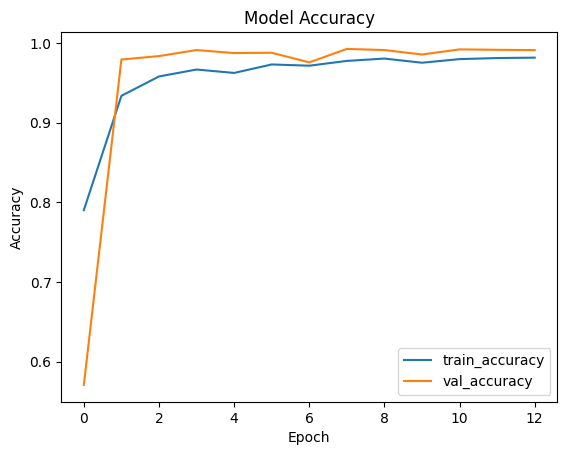

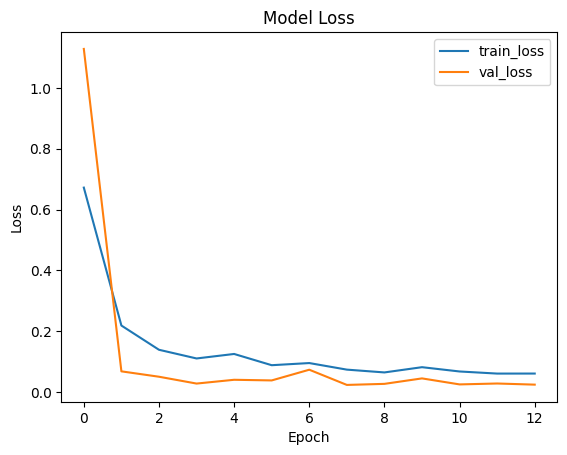

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

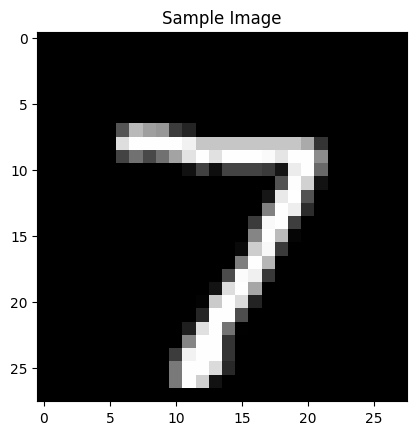

1/1 [==============================] - 0s 18ms/step


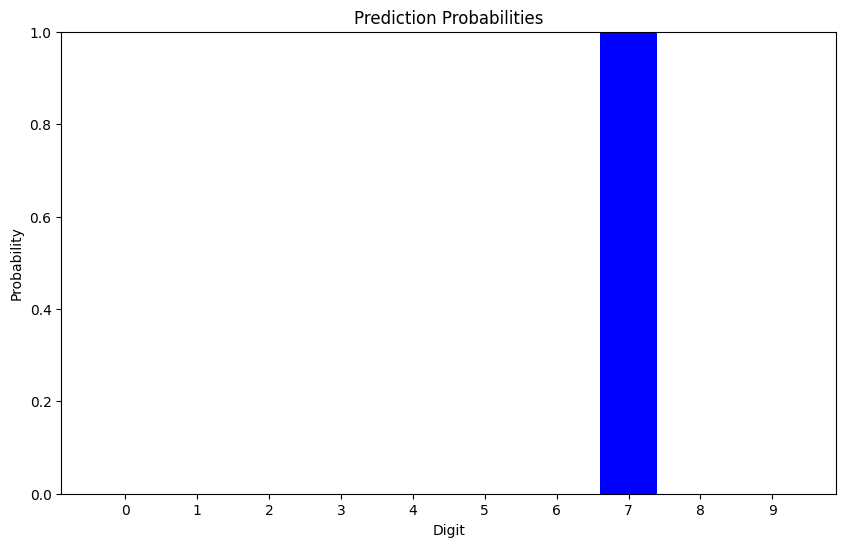

Predicted Class: 7


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 새로운 손글씨 이미지 로드 (여기서는 예시로 MNIST 테스트 데이터의 첫 번째 이미지를 사용)
sample_image = x_test[0]

# 이미지 확인
plt.imshow(sample_image.reshape(28, 28), cmap='gray')
plt.title('Sample Image')
plt.show()

# 이미지 전처리 (MNIST와 동일한 전처리 과정 적용)
sample_image = sample_image.reshape(1, 28, 28, 1)  # 모델 입력 형태에 맞게 재조정

# 예측
prediction = model.predict(sample_image)
predicted_class = np.argmax(prediction)

# 예측 확률 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(10), prediction[0], color='blue')
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.title('Prediction Probabilities')
plt.xticks(range(10))
plt.ylim(0, 1)
plt.show()

print(f'Predicted Class: {predicted_class}')

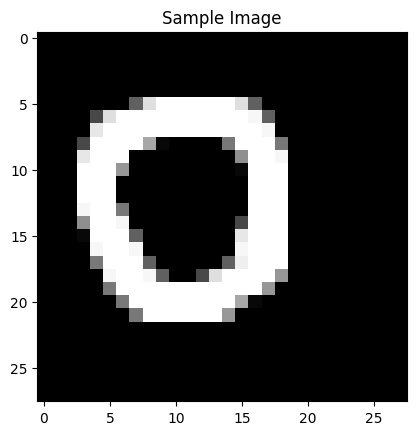

1/1 [==============================] - 0s 29ms/step


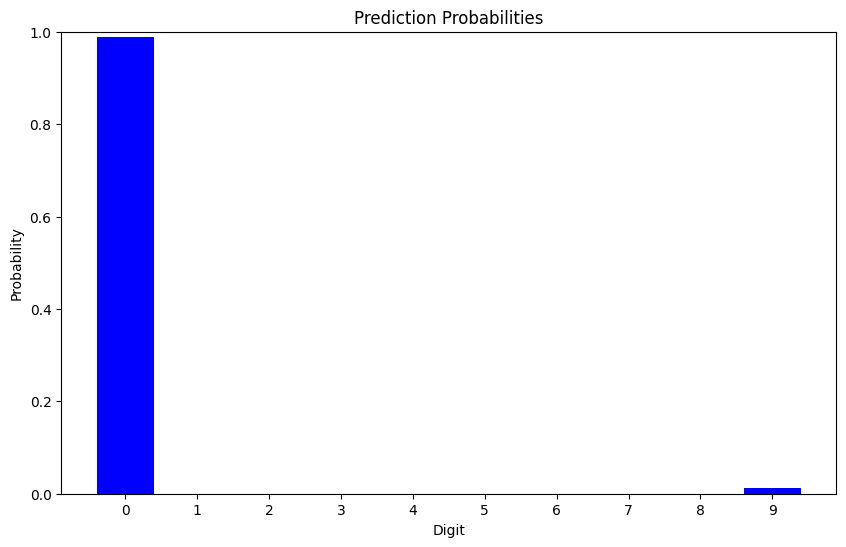

Predicted Class: 0


In [ ]:
# 새로운 손글씨 이미지 로드
sample_image_path = '0.png'
sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)

# 이미지 전처리 (MNIST와 동일한 전처리 과정 적용)
sample_image = cv2.resize(sample_image, (28, 28))
sample_image = sample_image.astype('float32') / 255
sample_image = sample_image.reshape(1, 28, 28, 1)

# 이미지 확인
plt.imshow(sample_image.reshape(28, 28), cmap='gray')
plt.title('Sample Image')
plt.show()

# 예측
prediction = model.predict(sample_image)
predicted_class = np.argmax(prediction)

# 예측 확률 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(10), prediction[0], color='blue')
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.title('Prediction Probabilities')
plt.xticks(range(10))
plt.ylim(0, 1)
plt.show()

print(f'Predicted Class: {predicted_class}')

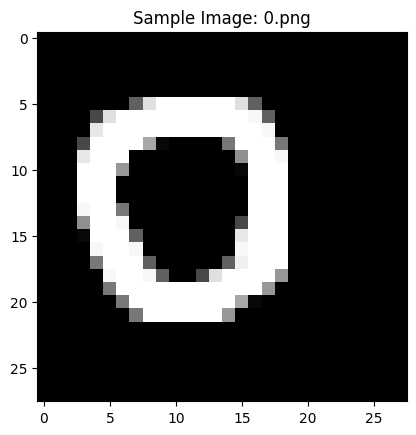

1/1 [==============================] - 0s 17ms/step


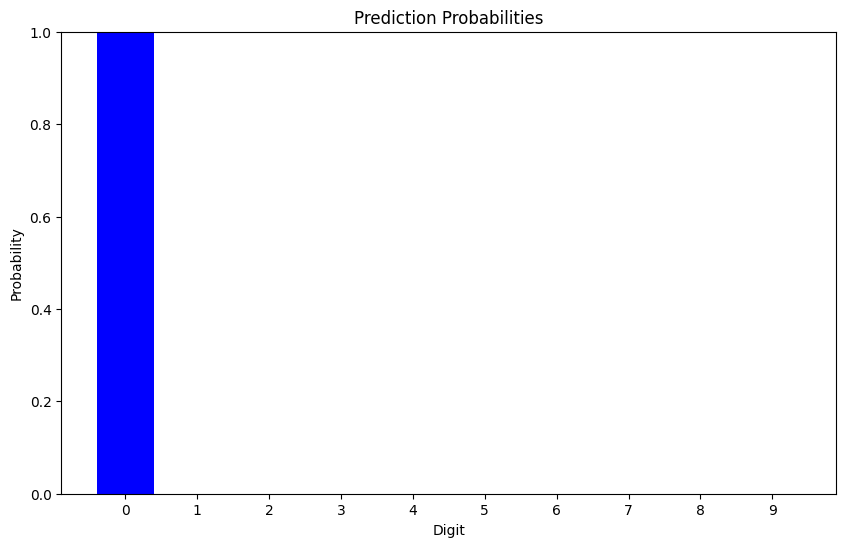

Predicted Class: 0


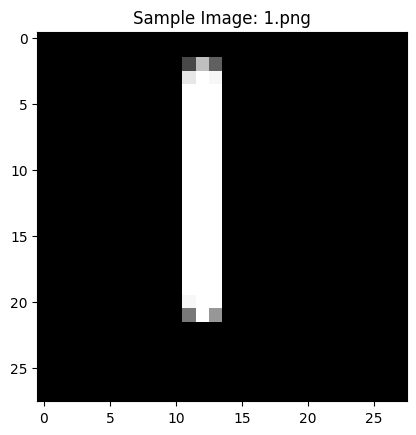

1/1 [==============================] - 0s 17ms/step


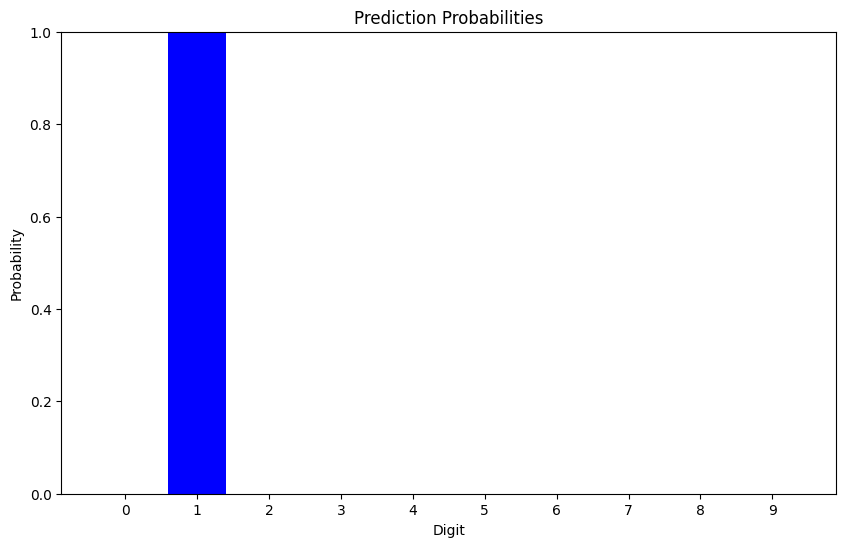

Predicted Class: 1


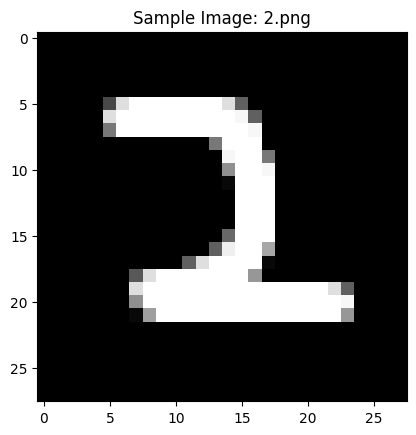

1/1 [==============================] - 0s 16ms/step


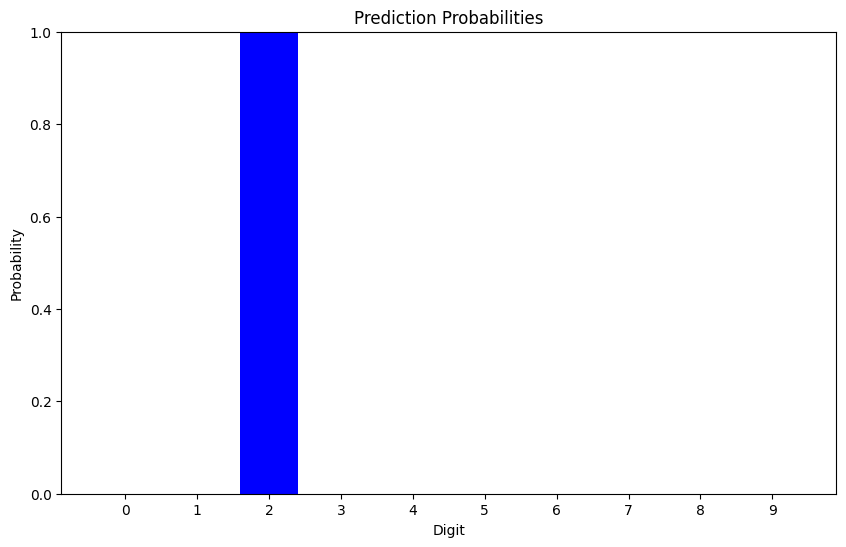

Predicted Class: 2


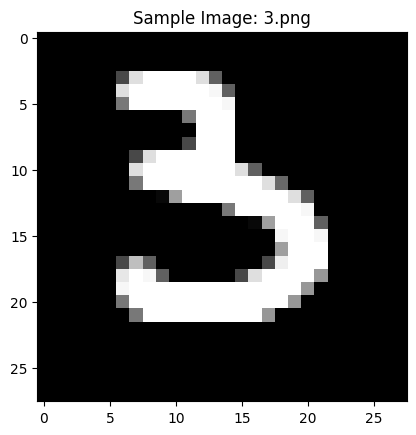

1/1 [==============================] - 0s 19ms/step


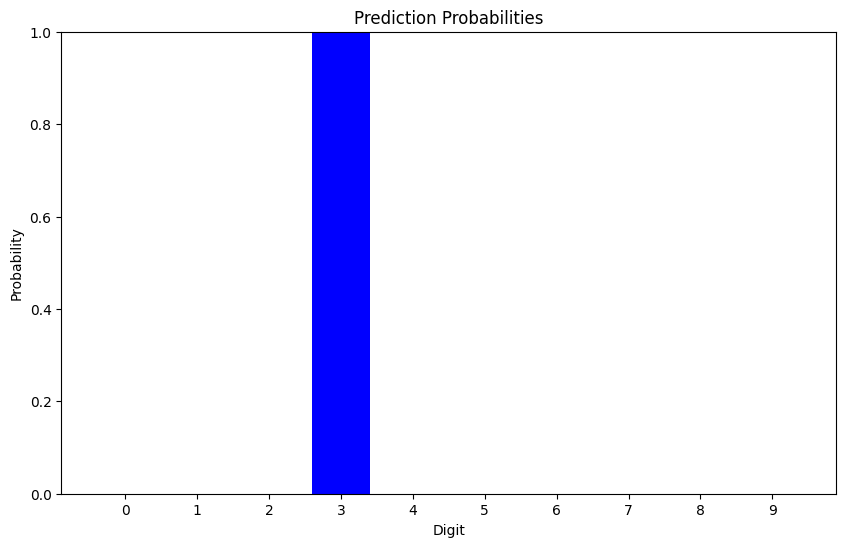

Predicted Class: 3


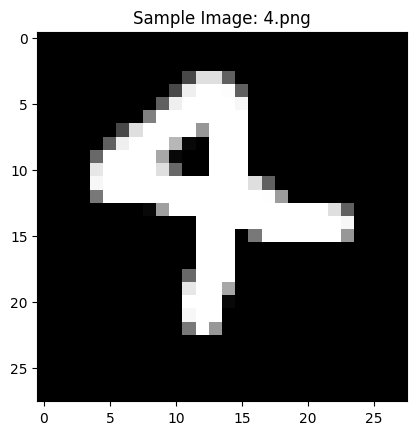

1/1 [==============================] - 0s 17ms/step


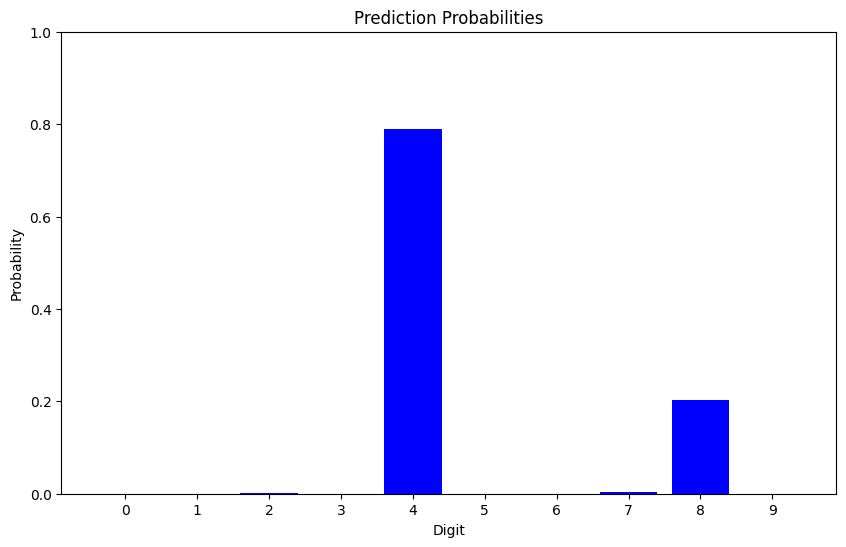

Predicted Class: 4


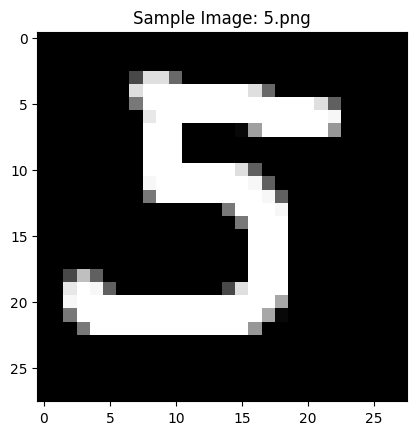

1/1 [==============================] - 0s 18ms/step


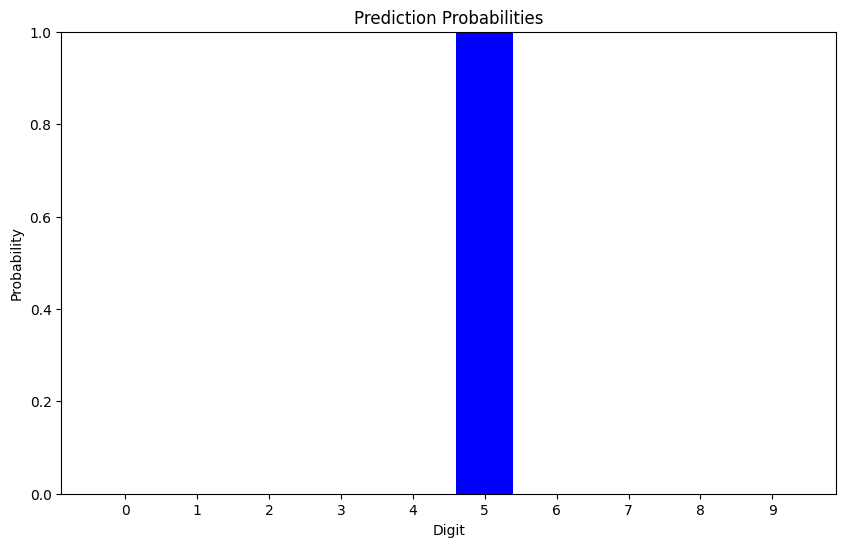

Predicted Class: 5


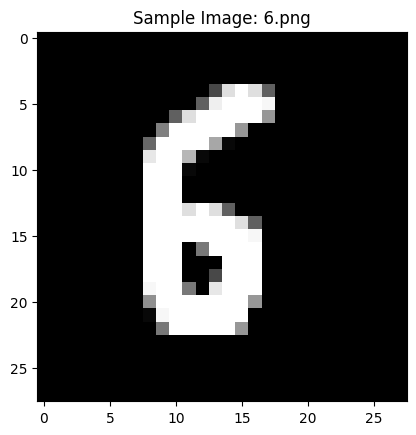

1/1 [==============================] - 0s 17ms/step


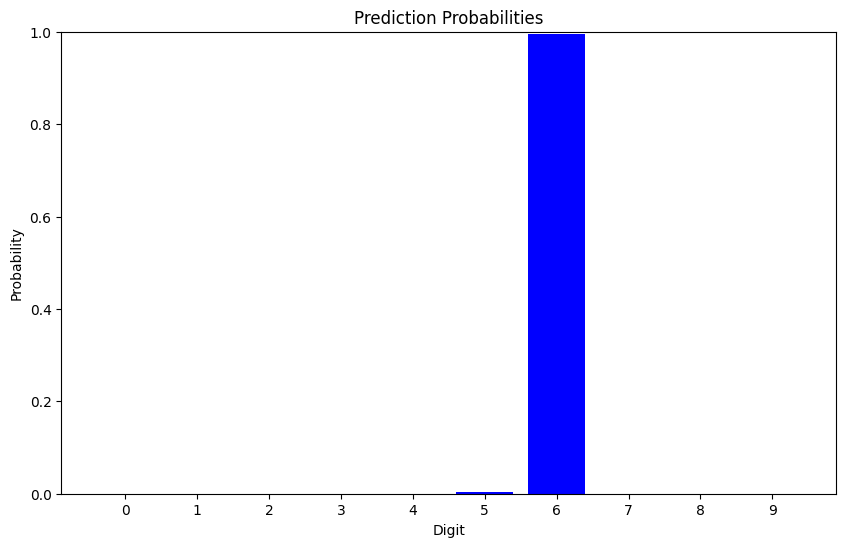

Predicted Class: 6


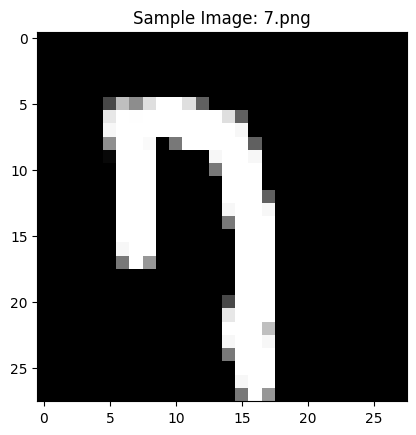

1/1 [==============================] - 0s 17ms/step


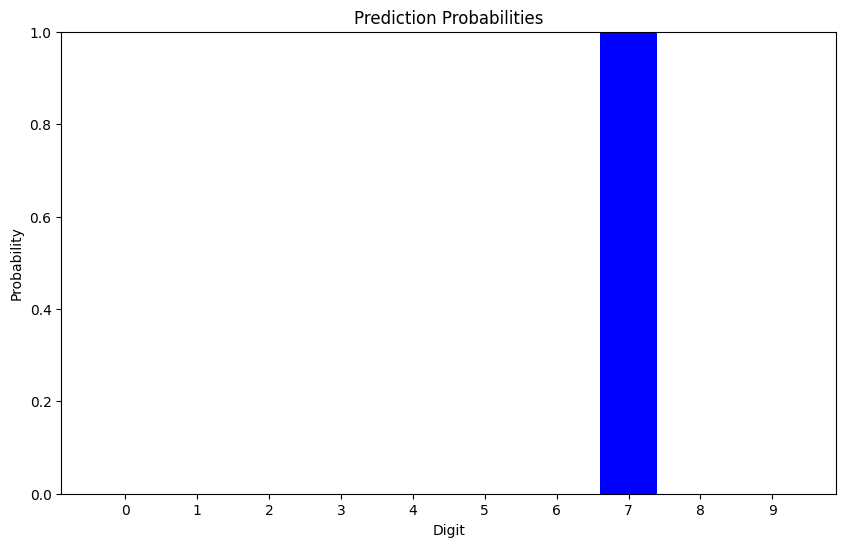

Predicted Class: 7


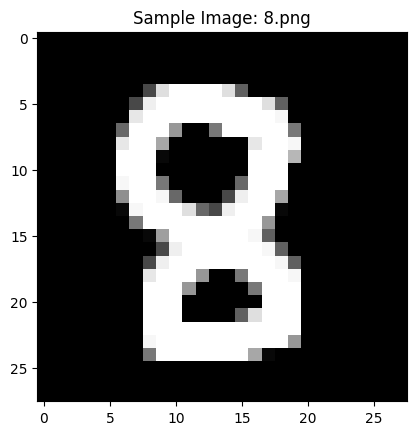

1/1 [==============================] - 0s 17ms/step


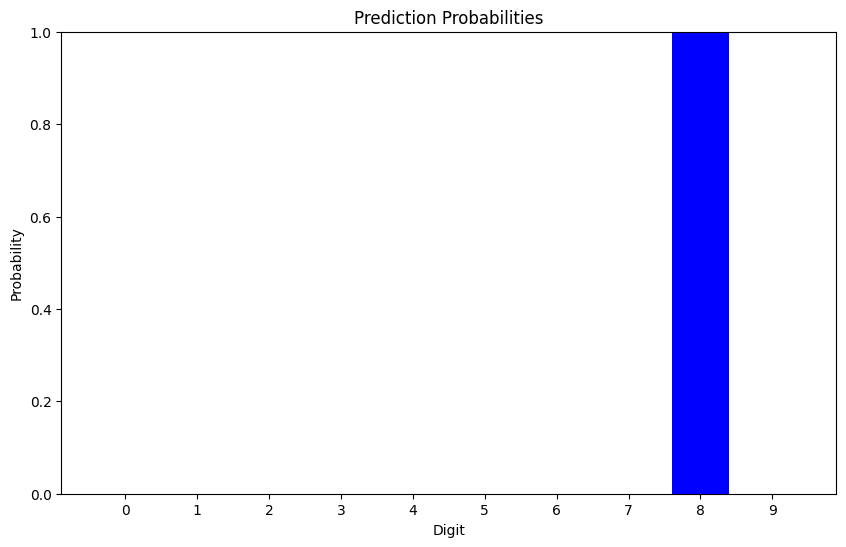

Predicted Class: 8


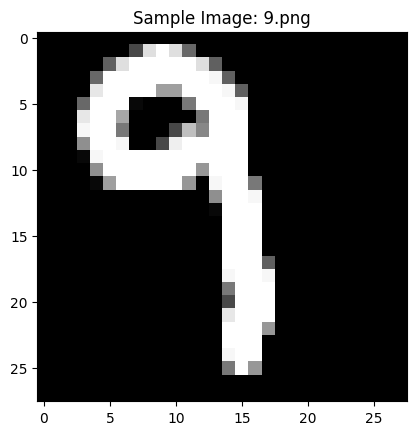

1/1 [==============================] - 0s 17ms/step


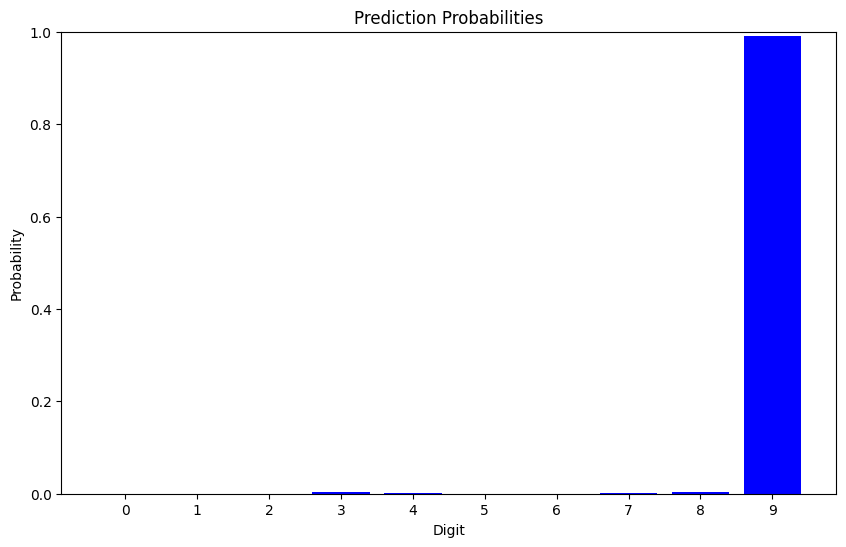

Predicted Class: 9


In [ ]:
# 이미지 예측 함수 정의
def predict_and_visualize(image_path):
    # 이미지 로드
    sample_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # 이미지 전처리
    sample_image = cv2.resize(sample_image, (28, 28))
    sample_image = sample_image.astype('float32') / 255
    sample_image = sample_image.reshape(1, 28, 28, 1)

    # 이미지 확인
    plt.imshow(sample_image.reshape(28, 28), cmap='gray')
    plt.title(f'Sample Image: {image_path}')
    plt.show()

    # 예측
    prediction = model.predict(sample_image)
    predicted_class = np.argmax(prediction)

    # 예측 확률 시각화
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), prediction[0], color='blue')
    plt.xlabel('Digit')
    plt.ylabel('Probability')
    plt.title('Prediction Probabilities')
    plt.xticks(range(10))
    plt.ylim(0, 1)
    plt.show()

    print(f'Predicted Class: {predicted_class}')

# 0.png에서 9.png까지 예측 및 시각화
for i in range(10):
    image_path = f'{i}.png'
    predict_and_visualize(image_path)

# 추가적인 모델 개선 방안 1

더 깊은 네트워크: \

* 추가적인 Conv2D 레이어와 Dense 레이어를 추가하여 네트워크의 깊이를 늘립니다. \

Regularization: \

 * L2 정규화를 추가하여 모델의 복잡성을 제어하고 과적합을 방지합니다. \

Ensemble Methods: \

 * 여러 모델을 학습시켜 결과를 앙상블하여 성능을 향상시킵니다. \

하이퍼파라미터 튜닝: \

 * 랜덤 서치(Random Search)나 그리드 서치(Grid Search)를 사용하여 최적의  하이퍼파라미터를 찾습니다. \

In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# 랜덤 시드 고정
np.random.seed(42)
tf.random.set_seed(42)

# 데이터 로드
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터 전처리
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 데이터 증강 설정
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(x_train)

# 모델 설계
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# 랜덤 학습률 설정 콜백
class RandomLearningRateScheduler(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.01):
        super(RandomLearningRateScheduler, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr

    def on_epoch_begin(self, epoch, logs=None):
        lr = np.random.uniform(self.base_lr, self.max_lr)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        print(f"Epoch {epoch+1}: Learning rate is {lr:.6f}")

# 콜백 설정 (조기 종료 및 학습률 감소)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
random_lr_scheduler = RandomLearningRateScheduler(base_lr=0.0001, max_lr=0.001)

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# 모델 학습
history = model.fit(datagen.flow(x_train, y_train, batch_size=200),
                    validation_data=(x_test, y_test),
                    epochs=30,
                    callbacks=[early_stopping, reduce_lr, random_lr_scheduler])

# 모델 평가
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

# 예측
predictions = model.predict(x_test)

11490434/11490434 [==============================] - 2s 0us/step
Epoch 1: Learning rate is 0.000254
Epoch 1/30
300/300 [==============================] - 28s 68ms/step - loss: 0.7162 - accuracy: 0.7707 - val_loss: 1.3282 - val_accuracy: 0.5759 - lr: 2.5383e-04
Epoch 2: Learning rate is 0.000638
Epoch 2/30
300/300 [==============================] - 20s 65ms/step - loss: 0.2289 - accuracy: 0.9294 - val_loss: 0.1101 - val_accuracy: 0.9701 - lr: 6.3822e-04
Epoch 3: Learning rate is 0.000549
Epoch 3/30
300/300 [==============================] - 20s 66ms/step - loss: 0.1503 - accuracy: 0.9538 - val_loss: 0.0796 - val_accuracy: 0.9746 - lr: 5.4866e-04
Epoch 4: Learning rate is 0.000210
Epoch 4/30
300/300 [==============================] - 20s 66ms/step - loss: 0.1180 - accuracy: 0.9633 - val_loss: 0.0832 - val_accuracy: 0.9722 - lr: 2.1024e-04
Epoch 5: Learning rate is 0.000917
Epoch 5/30
300/300 [==============================] - 20s 67ms/step - loss: 0.1252 - accuracy: 0.9605 - val_loss: 0.

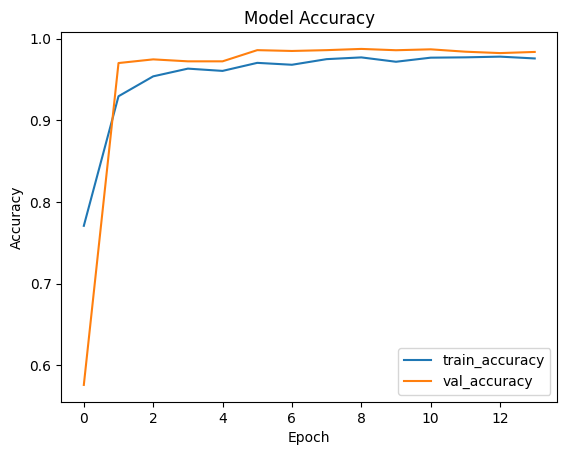

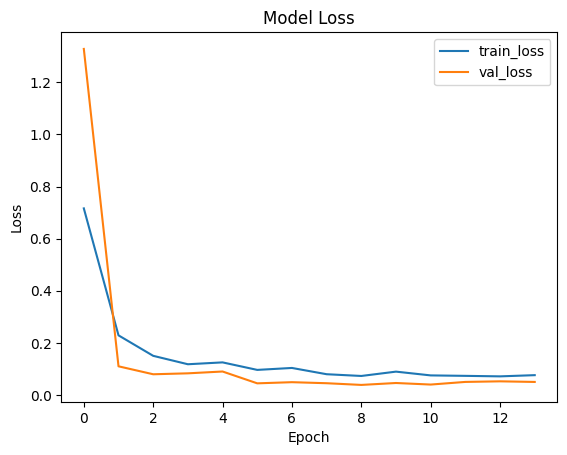

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

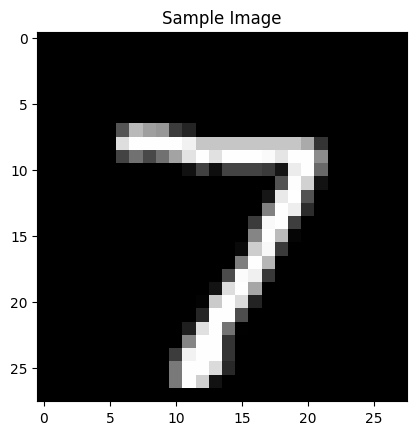

1/1 [==============================] - 0s 243ms/step


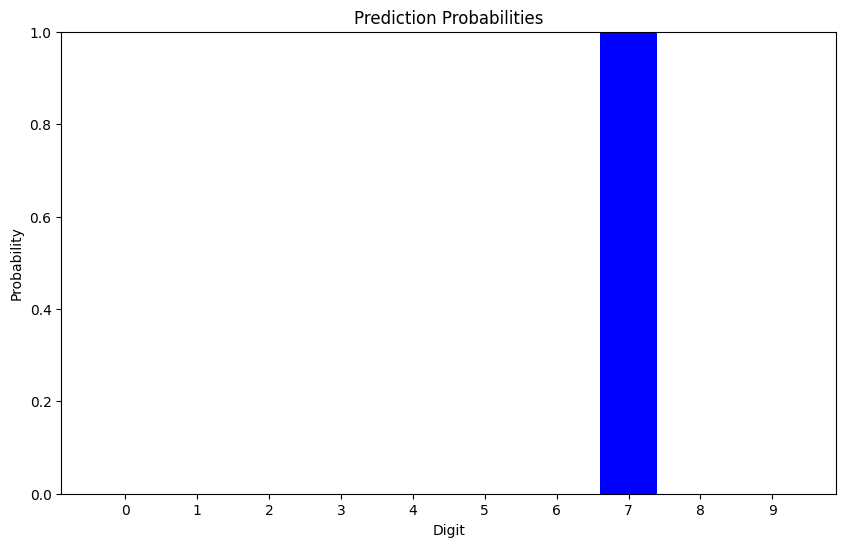

Predicted Class: 7


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 새로운 손글씨 이미지 로드 (여기서는 예시로 MNIST 테스트 데이터의 첫 번째 이미지를 사용)
sample_image = x_test[0]

# 이미지 확인
plt.imshow(sample_image.reshape(28, 28), cmap='gray')
plt.title('Sample Image')
plt.show()

# 이미지 전처리 (MNIST와 동일한 전처리 과정 적용)
sample_image = sample_image.reshape(1, 28, 28, 1)  # 모델 입력 형태에 맞게 재조정

# 예측
prediction = model.predict(sample_image)
predicted_class = np.argmax(prediction)

# 예측 확률 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(10), prediction[0], color='blue')
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.title('Prediction Probabilities')
plt.xticks(range(10))
plt.ylim(0, 1)
plt.show()

print(f'Predicted Class: {predicted_class}')

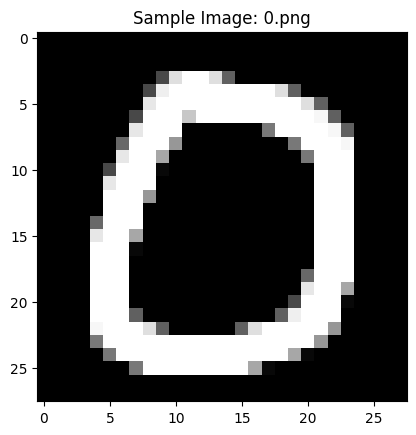

1/1 [==============================] - 0s 17ms/step


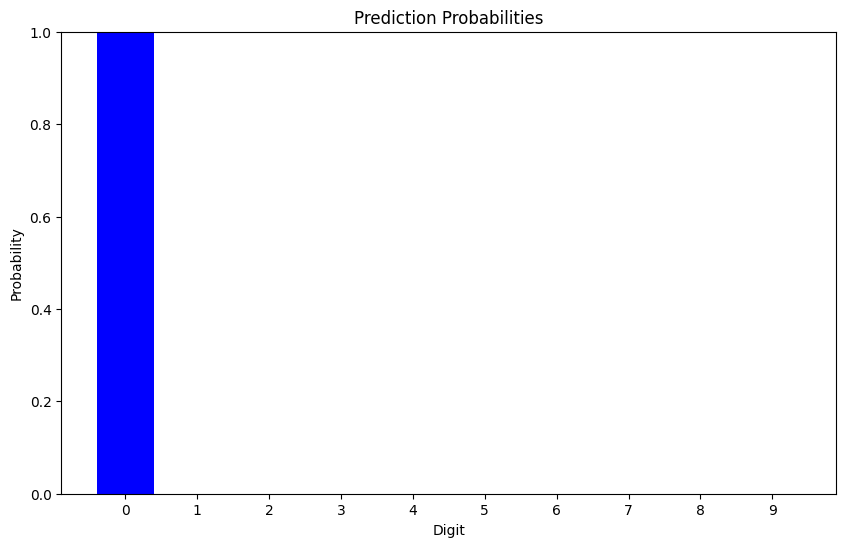

Predicted Class: 0


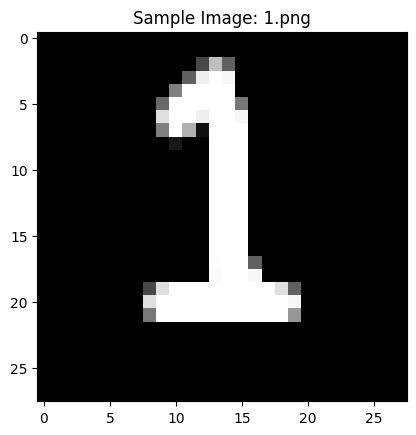

1/1 [==============================] - 0s 17ms/step


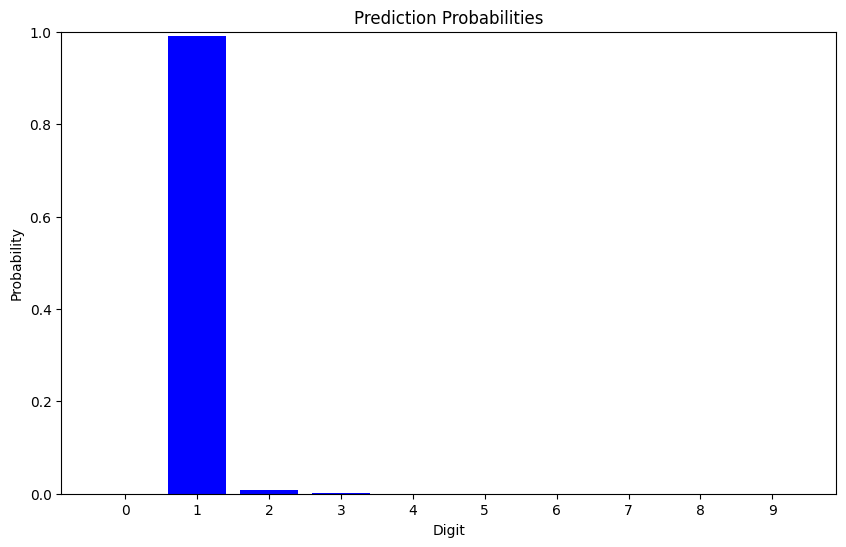

Predicted Class: 1


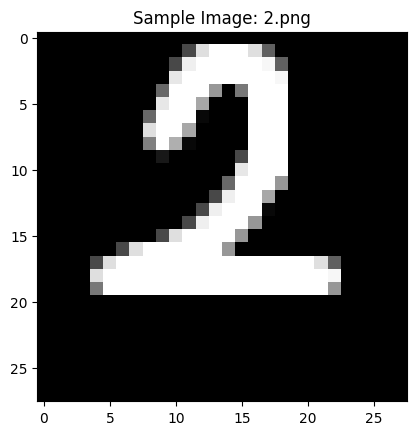

1/1 [==============================] - 0s 18ms/step


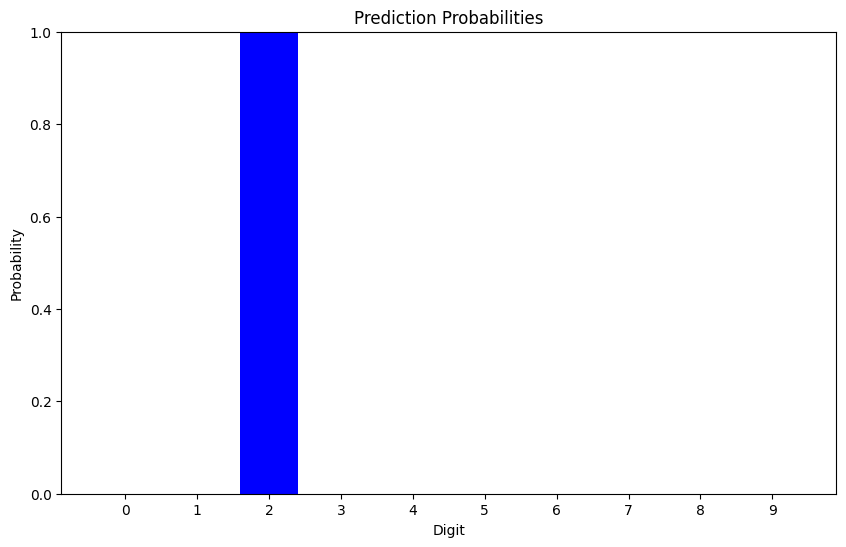

Predicted Class: 2


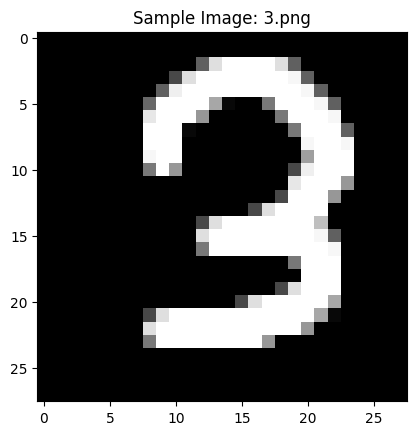

1/1 [==============================] - 0s 16ms/step


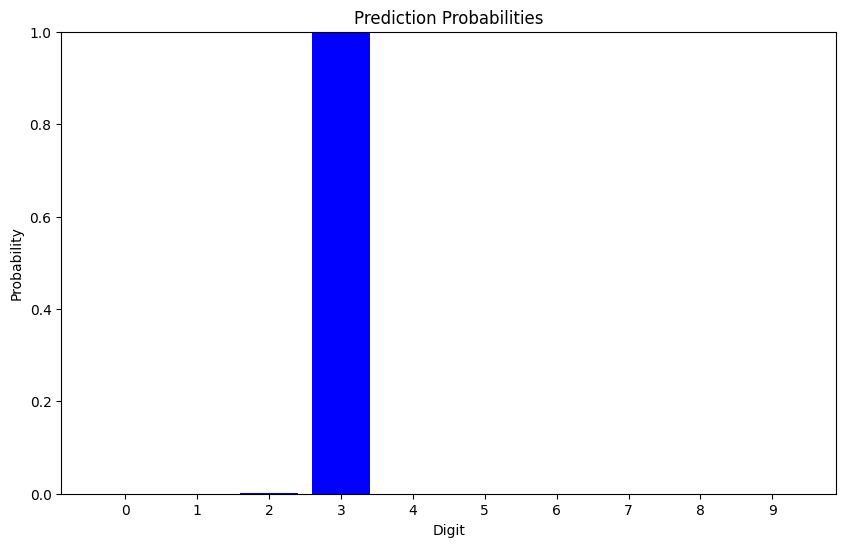

Predicted Class: 3


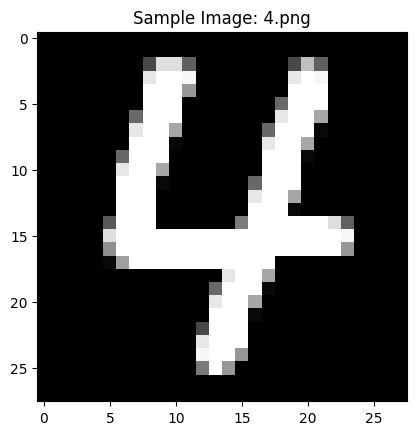

1/1 [==============================] - 0s 18ms/step


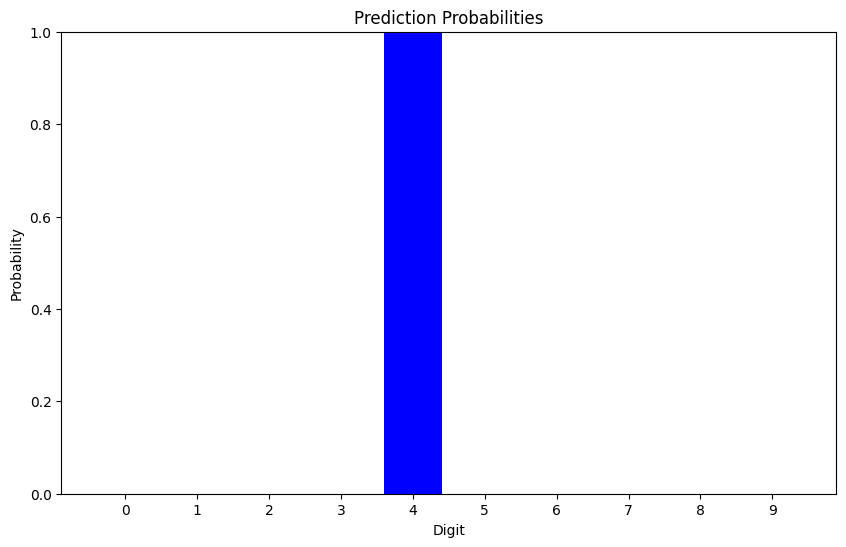

Predicted Class: 4


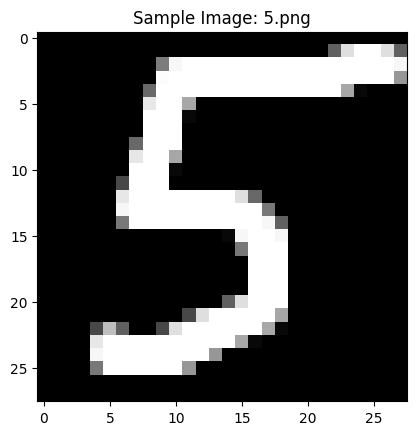

1/1 [==============================] - 0s 16ms/step


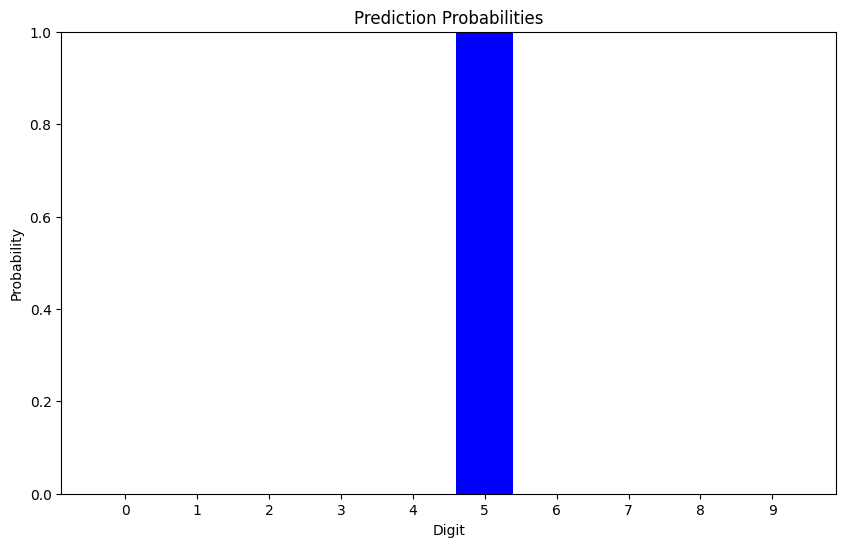

Predicted Class: 5


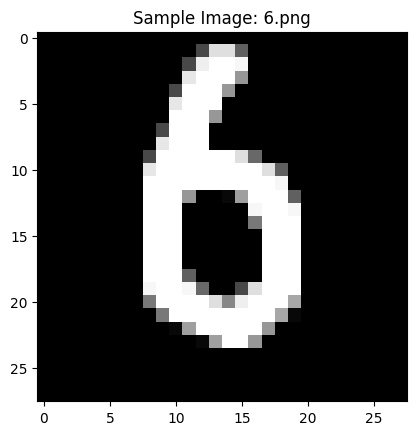

1/1 [==============================] - 0s 16ms/step


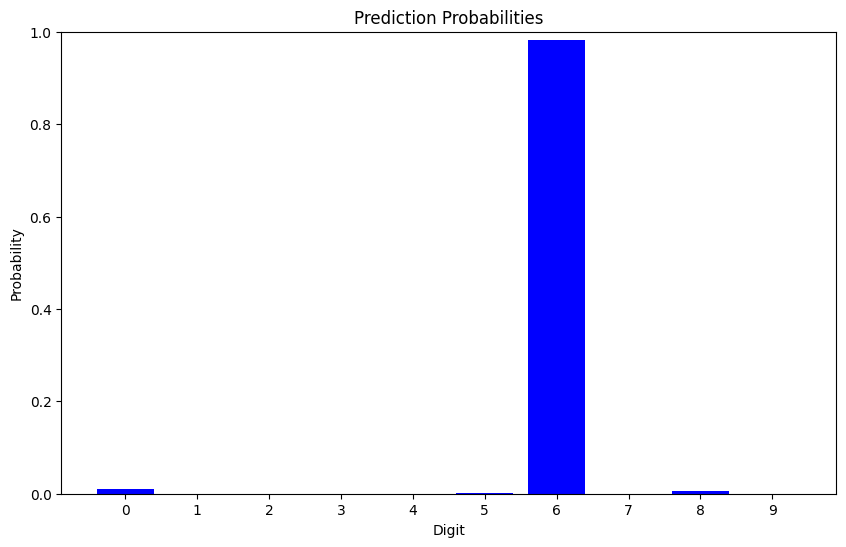

Predicted Class: 6


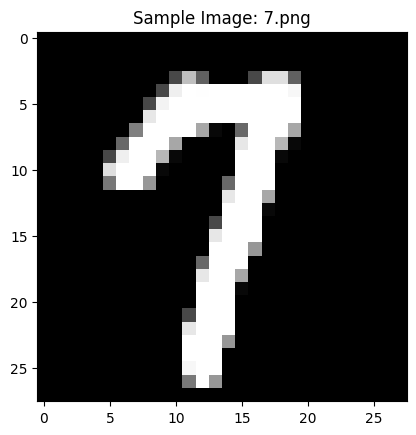

1/1 [==============================] - 0s 20ms/step


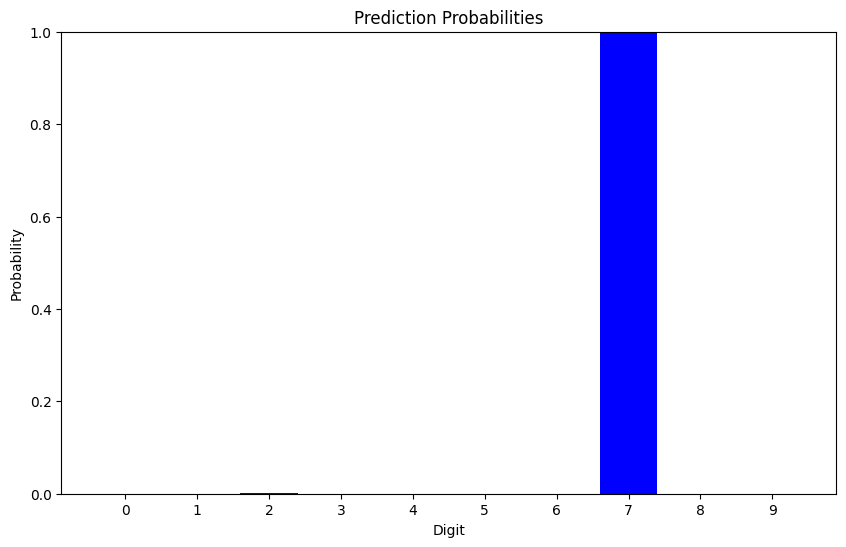

Predicted Class: 7


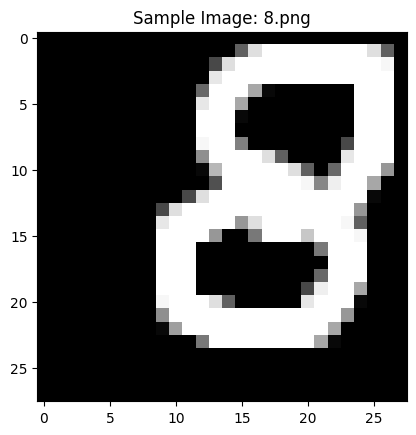

1/1 [==============================] - 0s 17ms/step


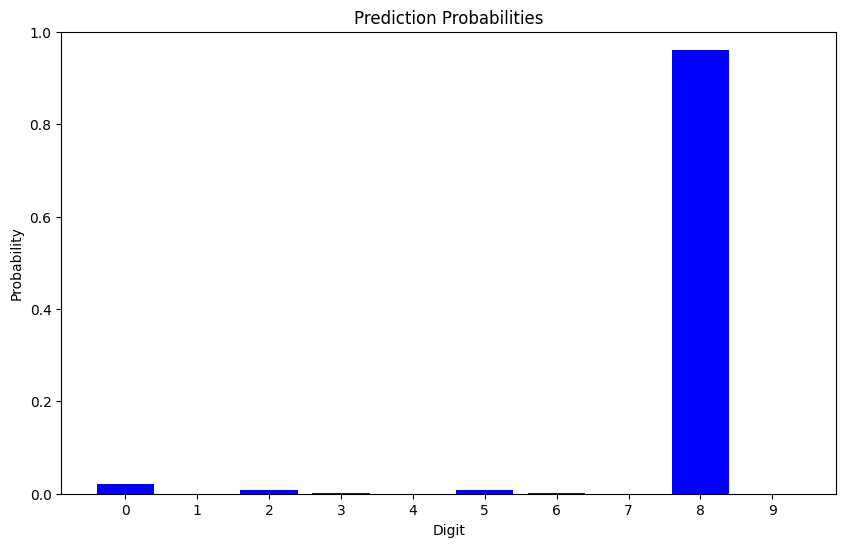

Predicted Class: 8


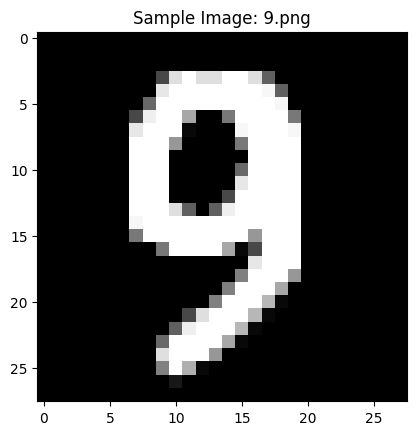

1/1 [==============================] - 0s 17ms/step


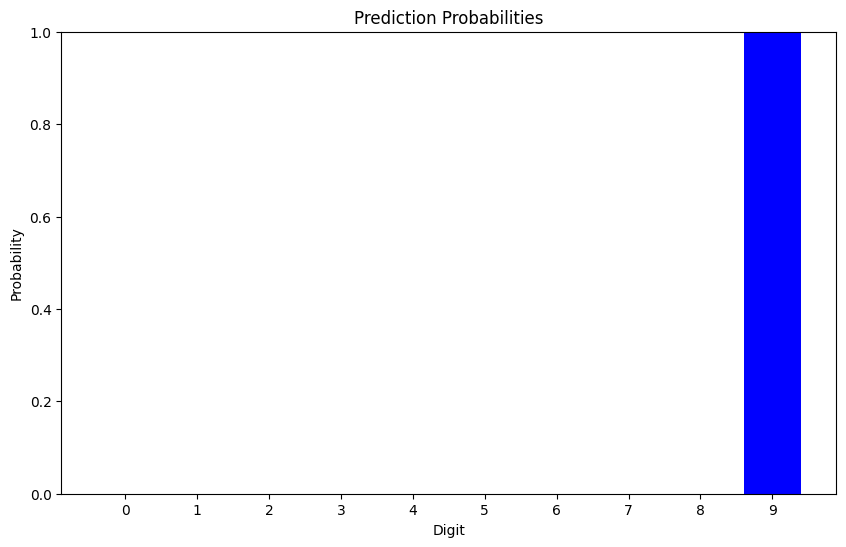

Predicted Class: 9


In [ ]:
# 이미지 예측 함수 정의
def predict_and_visualize(image_path):
    # 이미지 로드
    sample_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # 이미지 전처리
    sample_image = cv2.resize(sample_image, (28, 28))
    sample_image = sample_image.astype('float32') / 255
    sample_image = sample_image.reshape(1, 28, 28, 1)

    # 이미지 확인
    plt.imshow(sample_image.reshape(28, 28), cmap='gray')
    plt.title(f'Sample Image: {image_path}')
    plt.show()

    # 예측
    prediction = model.predict(sample_image)
    predicted_class = np.argmax(prediction)

    # 예측 확률 시각화
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), prediction[0], color='blue')
    plt.xlabel('Digit')
    plt.ylabel('Probability')
    plt.title('Prediction Probabilities')
    plt.xticks(range(10))
    plt.ylim(0, 1)
    plt.show()

    print(f'Predicted Class: {predicted_class}')

# 0.png에서 9.png까지 예측 및 시각화
for i in range(10):
    image_path = f'{i}.png'
    predict_and_visualize(image_path)

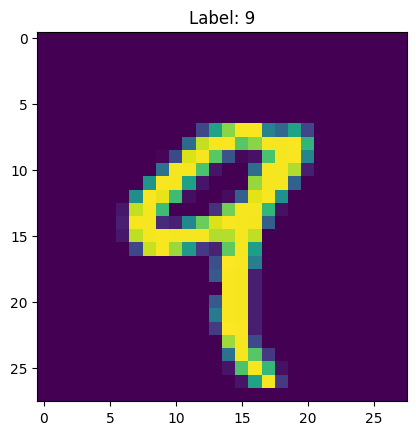

In [ ]:
import matplotlib.pyplot as plt
from keras.datasets import mnist

# MNIST 데이터셋 로드
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# 첫 번째 이미지 시각화
plt.imshow(train_images[4], cmap='viridis')
plt.title(f"Label: {train_labels[4]}")
plt.show()


In [ ]:
train_images[4]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  55,
        148, 210, 253, 253, 113,  87, 148,  55,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  87, 232,
        252, 253, 189, 210, 252, 252, 253, 168,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   4,  57, 242, 252,
        190,  65,   5,  12, 182, 252, 253, 116,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  96, 252, 252, 183,
         14,   0,   0,  92, 252, 252, 225,  21,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 132, 253, 252, 146,  14,
          0,   0,   0, 215, 252, 252,  79,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 126, 253, 247, 176,   9,   0,
          0,   8,  78, 245, 253, 129,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  16, 232, 252, 176,   0,   0,   0,
         36, 201, 252, 252, 169,  11,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  22, 252, 252,  30,  22, 119, 197,
        241, 253, 252, 251,  77,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  16, 231, 252, 253, 252, 252, 252,
        226, 227, 252, 231,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  55, 235, 253, 217, 138,  42,
         24, 192, 252, 143,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         62, 255, 253, 109,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         71, 253, 252,  21,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 253, 252,  21,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         71, 253, 252,  21,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        106, 253, 252,  21,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         45, 255, 253,  21,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 218, 252,  56,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   